In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import hvplot.pandas
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats as st

In [26]:
test_df = pd.read_csv("data/MERGED2021_22_PP.csv",low_memory=False)
# Read the CSV files
school_location = pd.read_csv('data/school_location.csv')


In [4]:
select_columns = test_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP", 
                          "ADM_RATE", "ADM_RATE_ALL", "COSTT4_A", "COSTT4_P"]]
select_columns.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN
2,100690,Amridge University,2,1.0,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN


In [5]:
# verifying that if there are null values for admission rate then it is a open adm college
indexadm = select_columns[ (select_columns['ADM_RATE'] == 'NaN') & (select_columns['ADM_RATE_ALL'] == 'NaN') & 
                          (select_columns['OPENADMP'] == 2.0) & (select_columns['OPENADMP'] == 3.0) ].index
adm_df = select_columns.drop(indexadm)
adm_df.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN
2,100690,Amridge University,2,1.0,NaN,NaN,NaN,NaN
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN


In [6]:
# dropping rows where both cost columns have null
clean_df = adm_df .dropna(subset=['COSTT4_A', 'COSTT4_P'], how='all')
# merging cost and admission columns
clean_df["cost_merged"] = clean_df["COSTT4_A"].combine_first(clean_df["COSTT4_P"])
clean_df["adm_merged"] = clean_df["ADM_RATE"].combine_first(clean_df["ADM_RATE_ALL"])
clean_df.head(5)


,UNITID,INSTNM,CONTROL,OPENADMP,ADM_RATE,ADM_RATE_ALL,COSTT4_A,COSTT4_P,cost_merged,adm_merged
0,100654,Alabama A & M University,1,2.0,0.7160,0.716006,21924.0,NaN,21924.0,0.7160
1,100663,University of Alabama at Birmingham,1,2.0,0.8854,0.885352,26248.0,NaN,26248.0,0.8854
3,100706,University of Alabama in Huntsville,1,2.0,0.7367,0.736724,24869.0,NaN,24869.0,0.7367
4,100724,Alabama State University,1,2.0,0.9799,0.979913,21938.0,NaN,21938.0,0.9799
5,100751,The University of Alabama,1,2.0,0.7890,0.789043,31050.0,NaN,31050.0,0.7890


In [7]:
#selecting only the needed columns
new_clean_df = clean_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP","cost_merged" ]]
new_clean_df.head(5)

,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged
0,100654,Alabama A & M University,1,2.0,21924.0
1,100663,University of Alabama at Birmingham,1,2.0,26248.0
3,100706,University of Alabama in Huntsville,1,2.0,24869.0
4,100724,Alabama State University,1,2.0,21938.0
5,100751,The University of Alabama,1,2.0,31050.0


In [25]:
new_clean_df.loc[new_clean_df["CONTROL"]==2]

,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged
10,100937,Birmingham-Southern College,2,2.0,33920.0
15,101189,Faulkner University,2,2.0,36457.0
21,101365,Herzing University-Birmingham,2,2.0,31202.0
22,101435,Huntingdon College,2,2.0,39177.0
23,101453,Heritage Christian University,2,1.0,16024.0
...,...,...,...,...,...
5955,495226,St. Louis Med Tech,2,1.0,13810.0
5961,495280,Indian Bible College,2,1.0,16608.0
5999,496399,Agape College of Business and Science,2,1.0,9754.0
6017,496724,Aesthetics Institute,2,1.0,20803.0


In [8]:
# grouping by open adm to get number of colleges in open and non open
group = new_clean_df.groupby("OPENADMP")["UNITID"].count()
group_df = pd.DataFrame(group)
group_df_reset = group_df.reset_index()
group_df_reset

,OPENADMP,UNITID
0,1.0,3412
1,2.0,1883


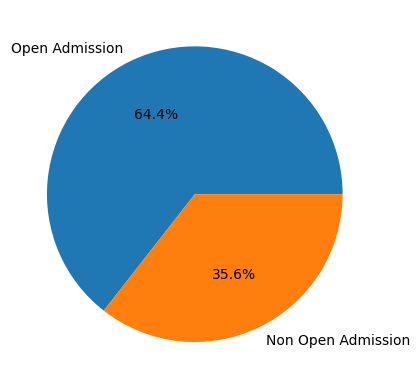

In [9]:
# displaying percentage of open vs non open colleges

labels = ["Open Admission", "Non Open Admission"]
ax = group_df_reset.plot.pie(y='UNITID', labels=labels, autopct='%1.1f%%')
ax.set_ylabel("")
ax.legend().set_visible(False)
plt.show()


## Non Open Admission

In [10]:

# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))



## Combined

In [11]:
# grouping by openadm and control

combine = new_clean_df.groupby(["OPENADMP", "CONTROL"])["cost_merged"].mean().round()
combine_df = pd.DataFrame(combine)
combine_df_reset = combine_df.reset_index()
combine_df_reset

,OPENADMP,CONTROL,cost_merged
0,1.0,1,14090.0
1,1.0,2,23600.0
2,1.0,3,23356.0
3,2.0,1,22295.0
4,2.0,2,44954.0
5,2.0,3,30837.0


In [12]:
#making the df to pivot so it can be used to plot
pivot = pd.pivot_table(data=combine_df_reset, index=['CONTROL'], 
                       columns=['OPENADMP'], values='cost_merged')
pivot

OPENADMP,1.0,2.0
CONTROL,,
1,14090.0,22295.0
2,23600.0,44954.0
3,23356.0,30837.0


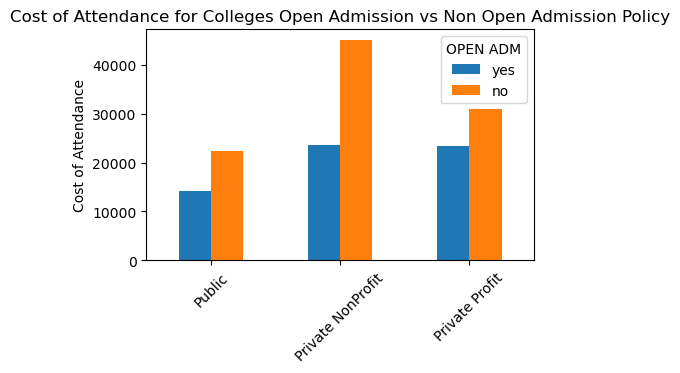

In [121]:
#plotting barchart
cb = pivot.plot(kind='bar', figsize=(5,3), title="Cost of Attendance for Colleges with Open Admission vs Non Open Admission Policy")
combined_labels = ['Public', 'Private NonProfit', 'Private Profit']
cb.set_xticklabels(combined_labels, rotation=45)
cb.set_xlabel("")
cb.set_ylabel("Cost of Attendance")
plt.legend(["yes", "no"], title="OPEN ADM")
#for p in ax.patches:
    #cb.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


In [137]:
# filtering to get all non open admission  & private non profit colleges
adm_clean_df = clean_df[["UNITID", "INSTNM", "CONTROL", "OPENADMP","cost_merged", "adm_merged" ]]
adm_loc = adm_clean_df.loc[(adm_clean_df["OPENADMP"]== 2.0) | (adm_clean_df["OPENADMP"]== 3.0)]

#dropping null values if any in admission requiremnt column
adm_cost = adm_loc .dropna(subset=["adm_merged"])
adm_cost["adm_merged"] = (adm_cost[["adm_merged"]]*100).round()
priv = adm_cost.loc[(adm_cost["CONTROL"]==2)]
priv


,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged,adm_merged
10,100937,Birmingham-Southern College,2,2.0,33920.0,66.0
15,101189,Faulkner University,2,2.0,36457.0,65.0
21,101365,Herzing University-Birmingham,2,2.0,31202.0,94.0
22,101435,Huntingdon College,2,2.0,39177.0,69.0
34,101693,University of Mobile,2,2.0,37823.0,64.0
...,...,...,...,...,...,...
5905,494278,EDP University of Puerto Rico-Humacao,2,2.0,11863.0,74.0
5906,494287,EDP University of Puerto Rico-Manati,2,2.0,16292.0,79.0
5909,494463,Derech Hachaim Seminary,2,2.0,16915.0,92.0
5920,494685,Urshan College,2,2.0,12916.0,72.0


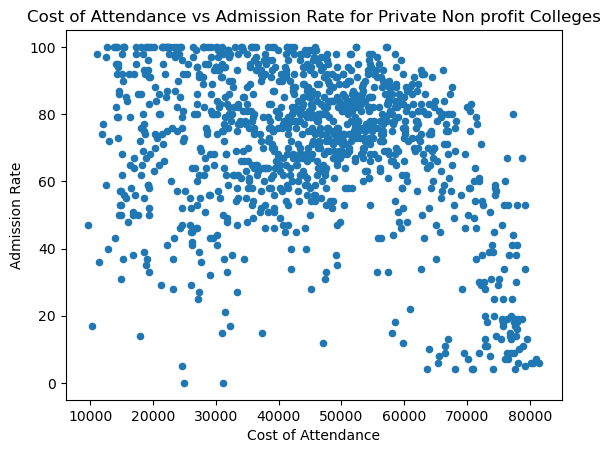

 The R squared value is -0.33


In [154]:
# creating scatter plot for admission rate vs cost
sc = priv.plot.scatter(x="cost_merged", y="adm_merged", 
                           title="Cost of Attendance vs Admission Rate for Private Non profit Colleges")
sc.set_xlabel("Cost of Attendance")
sc.set_ylabel("Admission Rate")
plt.show()

cost = priv["cost_merged"]
adm_rate = priv["adm_merged"]
correlation = st.pearsonr(cost, adm_rate)
print(f" The R squared value is {round(correlation[0],2)}")

<Axes: >

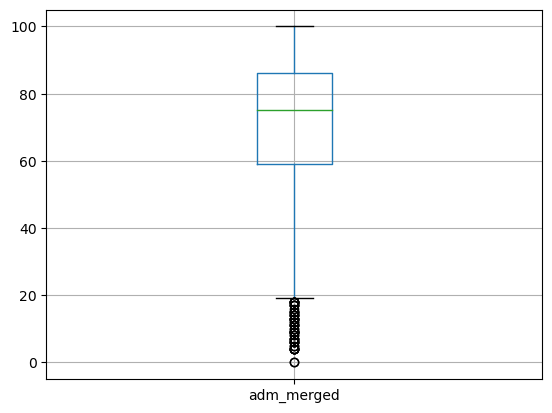

In [148]:
#box plot for admission column
priv.boxplot(column=['adm_merged'])

In [149]:
# removing outliers using iqr
# Calculate the IQR for each column
Q1_col1 = priv['cost_merged'].quantile(0.25)
Q3_col1 = priv['cost_merged'].quantile(0.75)
IQR_col1 = Q3_col1 - Q1_col1

Q1_col2 = priv['adm_merged'].quantile(0.25)
Q3_col2 = priv['adm_merged'].quantile(0.75)
IQR_col2 = Q3_col2 - Q1_col2

# Define the lower and upper bounds for outlier detection
lower_bound_col1 = Q1_col1 - 1.5 * IQR_col1
upper_bound_col1 = Q3_col1 + 1.5 * IQR_col1

lower_bound_col2 = Q1_col2 - 1.5 * IQR_col2
upper_bound_col2 = Q3_col2 + 1.5 * IQR_col2
#displaying outliers in cost column
outliers_cost = priv[(priv['cost_merged'] < lower_bound_col1) |
                     (priv['cost_merged'] > upper_bound_col1)]
outliers_cost

#displaying outliers in admission rate column
outliers_adm = priv[(priv['adm_merged'] < lower_bound_col2) |
                     (priv['adm_merged'] > upper_bound_col2)]
outliers_adm


# Filter out rows with values outside the lower and upper bounds for both columns
df_no_outliers = priv[(priv['cost_merged'] >= lower_bound_col1) & 
                          (priv['cost_merged'] <= upper_bound_col1) & 
                          (priv['adm_merged'] >= lower_bound_col2) & 
                          (priv['adm_merged'] <= upper_bound_col2)]
df_no_outliers

,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged,adm_merged
10,100937,Birmingham-Southern College,2,2.0,33920.0,66.0
15,101189,Faulkner University,2,2.0,36457.0,65.0
21,101365,Herzing University-Birmingham,2,2.0,31202.0,94.0
22,101435,Huntingdon College,2,2.0,39177.0,69.0
34,101693,University of Mobile,2,2.0,37823.0,64.0
...,...,...,...,...,...,...
5905,494278,EDP University of Puerto Rico-Humacao,2,2.0,11863.0,74.0
5906,494287,EDP University of Puerto Rico-Manati,2,2.0,16292.0,79.0
5909,494463,Derech Hachaim Seminary,2,2.0,16915.0,92.0
5920,494685,Urshan College,2,2.0,12916.0,72.0


The R squared value is -0.19


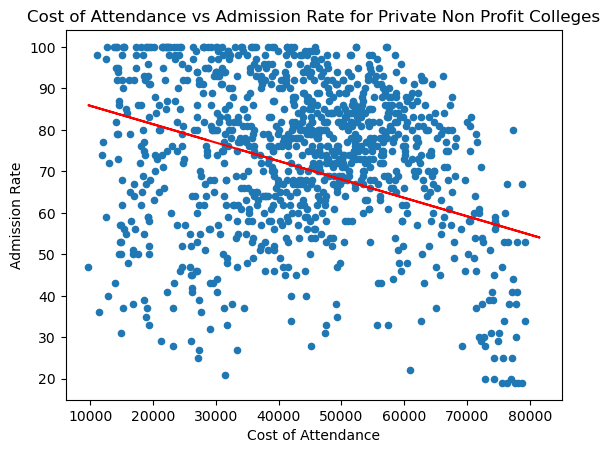

In [155]:
# creating scatter plot for admission rate vs cost(without outliers)

sc_ot= df_no_outliers.plot.scatter(x="cost_merged", y="adm_merged", 
                                   title="Cost of Attendance vs Admission Rate for Private Non Profit Colleges")
sc_ot.set_xlabel("Cost of Attendance")
sc_ot.set_ylabel("Admission Rate")
m, b = np.polyfit(cost, adm_rate, 1)
plt.plot(cost, m*cost+b, color='red', label='x={:.2f}y+{:.2f}'.format(m,b))
cost = df_no_outliers["cost_merged"]
adm_rate = df_no_outliers["adm_merged"]
correlation = st.pearsonr(cost, adm_rate)
print(f"The R squared value is {round(correlation[0],2)}")




In [152]:
#getting average of admission rate
average = df_no_outliers['adm_merged'].mean()
#getting rows those are below avg
below_avg = df_no_outliers.loc[df_no_outliers["adm_merged"] < average]
below_avg



,UNITID,INSTNM,CONTROL,OPENADMP,cost_merged,adm_merged
10,100937,Birmingham-Southern College,2,2.0,33920.0,66.0
15,101189,Faulkner University,2,2.0,36457.0,65.0
22,101435,Huntingdon College,2,2.0,39177.0,69.0
34,101693,University of Mobile,2,2.0,37823.0,64.0
39,101912,Oakwood University,2,2.0,37238.0,72.0
...,...,...,...,...,...,...
5794,491710,Yeshiva Gedolah of Cliffwood,2,2.0,14850.0,57.0
5813,491914,Yeshiva Gedola Tiferes Yerachmiel,2,2.0,14800.0,31.0
5868,493594,Yeshiva of Ocean,2,2.0,14550.0,50.0
5880,493716,Yeshiva Gedola Tiferes Yaakov Yitzchok,2,2.0,19000.0,37.0


-0.19


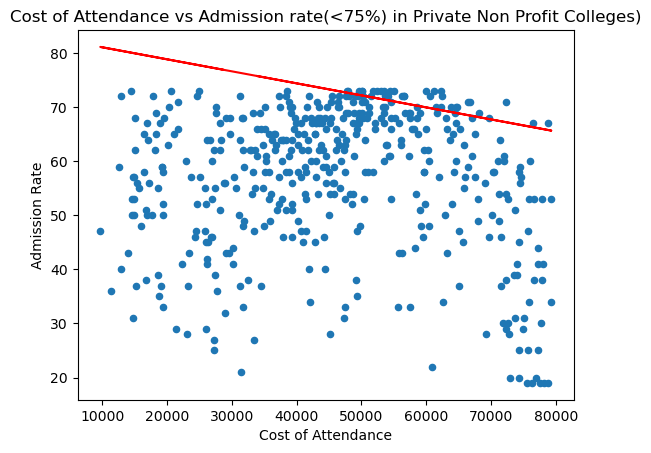

In [156]:
#plotting for below avg admission rate
blw =below_avg.plot.scatter(x="cost_merged", y="adm_merged", 
                            title="Cost of Attendance vs Admission rate(<75%) in Private Non Profit Colleges)")
blw.set_xlabel("Cost of Attendance")
blw.set_ylabel("Admission Rate")
below_avg_cost = df_no_outliers["cost_merged"]
below_avg_adm_rate = df_no_outliers["adm_merged"]
m, b = np.polyfit(below_avg_cost, below_avg_adm_rate, 1)
plt.plot(below_avg_cost, m*below_avg_cost+b, color='red') 

below_avg_correlation = st.pearsonr(below_avg_cost, below_avg_adm_rate)
print(f"{round(below_avg_correlation[0],2)}")